In [1]:
import pandas as pd
import numpy as np
import os

In [76]:
# load training data and do preprocessing
mean = pd.DataFrame()
maximum = pd.DataFrame()
minimum = pd.DataFrame()
for file in os.listdir('set-a/'):
    df = pd.read_csv('set-a/' + file)
    df = df.pivot(columns='Parameter',values='Value')
    mean = mean.append(df.mean(),ignore_index=True)
    maximum = maximum.append(df.max(),ignore_index=True)
    minimum = minimum.append(df.min(),ignore_index=True)
static = mean[['RecordID','Age','Height','Gender','ICUType']]
mean = mean.drop(['RecordID','Age','Height','Gender','ICUType'],axis=1).add_suffix('_mean')
maximum = maximum.drop(['RecordID','Age','Height','Gender','ICUType'],axis=1).add_suffix('_max')
minimum = minimum.drop(['RecordID','Age','Height','Gender','ICUType'],axis=1).add_suffix('_min')
train = pd.concat([static,mean,maximum,minimum],axis=1,sort=False)

label_train = pd.read_csv('Outcomes-a.txt')[['RecordID','In-hospital_death']]
train = pd.merge(pd.get_dummies(train,columns=['ICUType'],drop_first=True),label_train).drop('RecordID',axis=1)

In [77]:
# load watching data and do preprocessing
mean = pd.DataFrame()
maximum = pd.DataFrame()
minimum = pd.DataFrame()
for file in os.listdir('set-b/'):
    df = pd.read_csv('set-b/' + file)
    df = df.pivot(columns='Parameter',values='Value')
    mean = mean.append(df.mean(),ignore_index=True)
    maximum = maximum.append(df.max(),ignore_index=True)
    minimum = minimum.append(df.min(),ignore_index=True)
static = mean[['RecordID','Age','Height','Gender','ICUType']]
mean = mean.drop(['RecordID','Age','Height','Gender','ICUType'],axis=1).add_suffix('_mean')
maximum = maximum.drop(['RecordID','Age','Height','Gender','ICUType'],axis=1).add_suffix('_max')
minimum = minimum.drop(['RecordID','Age','Height','Gender','ICUType'],axis=1).add_suffix('_min')
watch = pd.concat([static,mean,maximum,minimum],axis=1,sort=False)

label_watch = pd.read_csv('Outcomes-b.txt')[['RecordID','In-hospital_death']]
watch = pd.merge(pd.get_dummies(watch,columns=['ICUType'],drop_first=True),label_watch).drop('RecordID',axis=1)

In [78]:
# load testing data and do preprocessing
mean = pd.DataFrame()
maximum = pd.DataFrame()
minimum = pd.DataFrame()
for file in os.listdir('set-c/'):
    df = pd.read_csv('set-c/' + file)
    df = df.pivot(columns='Parameter',values='Value')
    mean = mean.append(df.mean(),ignore_index=True)
    maximum = maximum.append(df.max(),ignore_index=True)
    minimum = minimum.append(df.min(),ignore_index=True)
static = mean[['RecordID','Age','Height','Gender','ICUType']]
mean = mean.drop(['RecordID','Age','Height','Gender','ICUType'],axis=1).add_suffix('_mean')
maximum = maximum.drop(['RecordID','Age','Height','Gender','ICUType'],axis=1).add_suffix('_max')
minimum = minimum.drop(['RecordID','Age','Height','Gender','ICUType'],axis=1).add_suffix('_min')
test = pd.concat([static,mean,maximum,minimum],axis=1,sort=False)

label_test = pd.read_csv('Outcomes-c.txt')[['RecordID','In-hospital_death']]
test = pd.merge(pd.get_dummies(test,columns=['ICUType'],drop_first=True),label_test).drop('RecordID',axis=1)

In [91]:
test = test.drop(list(set(test).difference(set(train))),axis=1)
test = test.reindex(sorted(test.columns),axis=1)
train = train.reindex(sorted(train.columns),axis=1)
watch = watch.reindex(sorted(watch.columns),axis=1)
train = train.replace(-1,np.NaN).fillna(train.mean())
watch = watch.replace(-1,np.NaN).fillna(watch.mean())
test = test.replace(-1,np.NaN).fillna(train.mean())

In [24]:
train.to_csv('train.csv',index=False)
watch.to_csv('watch.csv',index=False)
test.to_csv('test.csv',index=False)

-------------------------------------- separate -----------------------------------------

In [2]:
train = pd.read_csv('train.csv')
watch = pd.read_csv('watch.csv')
test = pd.read_csv('test.csv')
train_X = train.drop('In-hospital_death',axis=1)
train_y = train['In-hospital_death']
watch_X = watch.drop('In-hospital_death',axis=1)
watch_y = watch['In-hospital_death']
test_X = test.drop('In-hospital_death',axis=1)
test_y = test['In-hospital_death']

In [3]:
from sklearn import metrics
import xgboost as xgb

In [6]:
from sklearn.feature_selection import RFECV

In [16]:
model = xgb.XGBClassifier(max_depth=3,n_estimators=100,learning_rate=0.08,scale_pos_weight=3)
model.fit(train_X,train_y)
yhat = model.predict(watch_X)
for i in range(len(yhat)):
    if yhat[i] > 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
tn, fp, fn, tp = metrics.confusion_matrix(watch_y, yhat).ravel()
min(tp/(tp+fn),tp/(tp+fp))

C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.4014084507042254

In [24]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

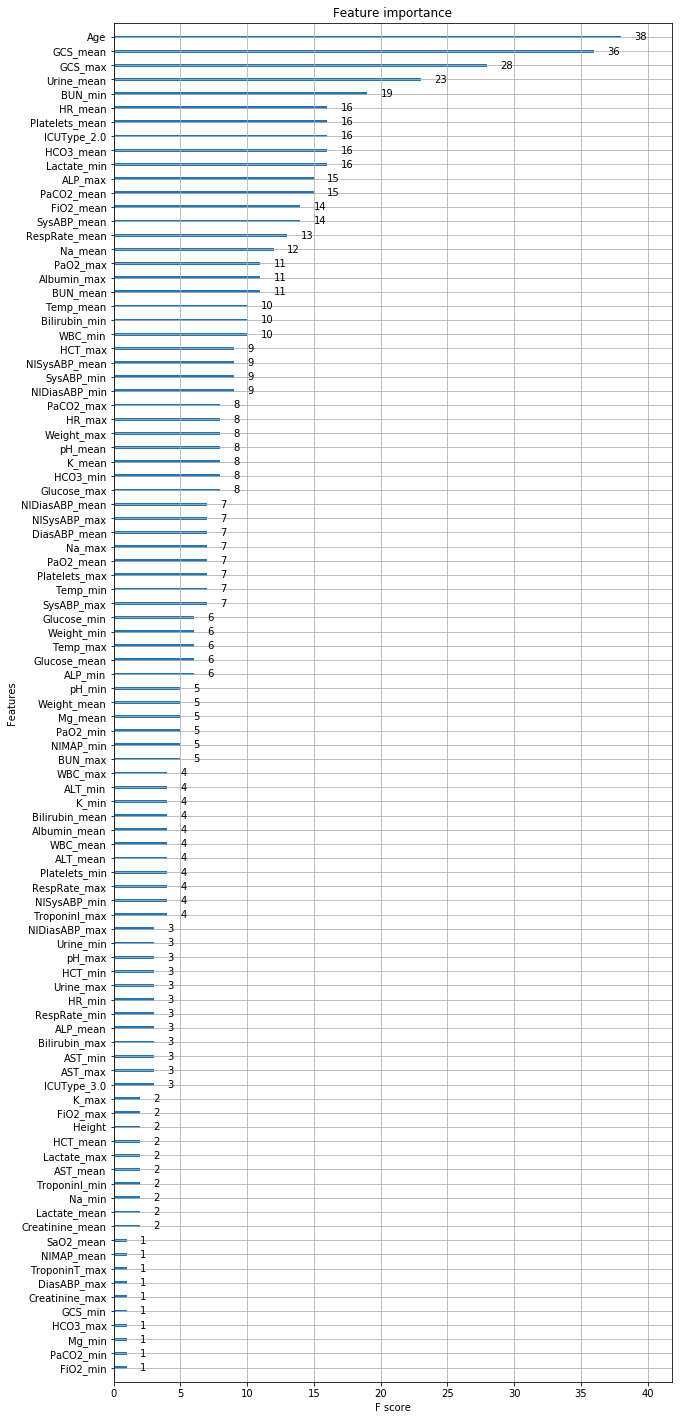

In [26]:
fig, ax = plt.subplots(figsize=(10, 25))
plot_importance(model, ax=ax)

In [27]:
select = []
for item in list(model.feature_importances_):
    select.append(bool(item))
    
train = train.iloc[:,select]
test = test.drop(list(set(test).difference(set(train))),axis=1)
watch = watch.drop(list(set(watch).difference(set(train))),axis=1)
train_X = train.drop('In-hospital_death',axis=1)
train_y = train['In-hospital_death']
watch_X = watch.drop('In-hospital_death',axis=1)
watch_y = watch['In-hospital_death']
test_X = test.drop('In-hospital_death',axis=1)
test_y = test['In-hospital_death']

In [29]:
rfe = RFECV(xgb.XGBClassifier(max_depth=5,n_estimators=150,learning_rate=0.08,scale_pos_weight=3),scoring='roc_auc')

In [30]:
rfe.fit(train,train['In-hospital_death'])

RFECV(cv=None,
   estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=None,
       silent=True, subsample=1),
   n_jobs=1, scoring='roc_auc', step=1, verbose=0)

In [31]:
train = train.iloc[:,rfe.get_support()]
test = test.drop(list(set(test).difference(set(train))),axis=1)
watch = watch.drop(list(set(watch).difference(set(train))),axis=1)
train_X = train.drop('In-hospital_death',axis=1)
train_y = train['In-hospital_death']
watch_X = watch.drop('In-hospital_death',axis=1)
watch_y = watch['In-hospital_death']
test_X = test.drop('In-hospital_death',axis=1)
test_y = test['In-hospital_death']

------------------------------------------ separate ----------------------------------------------------------------------------

In [32]:
from hyperopt import hp, fmin, tpe

In [33]:
space = {'max_depth': hp.quniform('max_depth',2,5,1),
         'learning_rate': hp.uniform('learning_rate',0.01,0.1),
         'n_estimators': hp.quniform('n_estimators',50,150,1),
         'gamma': hp.uniform('gamma',0,10),
         'min_child_weight': hp.uniform('min_child_weight',0,5),
         'max_delta_step': hp.uniform('max_delta_step',0,10),
         'subsample': hp.uniform('subsample',0.5,1),
         'colsample_bytree': hp.uniform('colsample_bytree',0.5,1),
         'reg_alpha': hp.uniform('reg_alpha',0,10),
         'reg_lambda': hp.uniform('reg_lambda',0,10),
         'scale_pos_weight': hp.uniform('scale_pos_weight',3,6)
        }

In [34]:
def objective(params):
    bst = xgb.XGBClassifier(max_depth=int(params['max_depth']),learning_rate=params['learning_rate'],objective='binary:logistic',
                            n_estimators=int(params['n_estimators']),gamma=params['gamma'],
                            min_child_weight=params['min_child_weight'],max_delta_step=params['max_delta_step'],
                            subsample=params['subsample'],colsample_bytree=params['colsample_bytree'],
                            reg_alpha=params['reg_alpha'],reg_lambda=params['reg_lambda'],
                            scale_pos_weight=params['scale_pos_weight'])
    bst.fit(train_X,train_y)
    yhat = bst.predict(watch_X)
    for i in range(len(yhat)):
        if yhat[i] > 0.5:
            yhat[i] = 1
        else:
            yhat[i] = 0
    tn, fp, fn, tp = metrics.confusion_matrix(watch_y, yhat).ravel()
    return 1-min(tp/(tp+fn),tp/(tp+fp))

In [35]:
param = fmin(objective,space,algo=tpe.suggest,max_evals=400)
bst = xgb.XGBClassifier(max_depth=int(param['max_depth']),learning_rate=param['learning_rate'],objective='binary:logistic',
                            n_estimators=int(param['n_estimators']),gamma=param['gamma'],
                            min_child_weight=param['min_child_weight'],max_delta_step=param['max_delta_step'],
                            subsample=param['subsample'],colsample_bytree=param['colsample_bytree'],
                            reg_alpha=param['reg_alpha'],reg_lambda=param['reg_lambda'],
                            scale_pos_weight=param['scale_pos_weight'])
bst.fit(train_X,train_y)
yhat = bst.predict(test_X)
for i in range(len(yhat)):
    if yhat[i] > 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
tn, fp, fn, tp = metrics.confusion_matrix(test_y, yhat).ravel()
min(tp/(tp+fn),tp/(tp+fp))

C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\chiji\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

0.5082956259426847

--------------------------------------------- separate -----------------------------------------------------------------------

In [113]:
df = open('param.txt','w')
df.write(str(param))
df.close()

In [37]:
model.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.08,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 3,
 'seed': 0,
 'silent': 1,
 'subsample': 1}

In [38]:
param

{'colsample_bytree': 0.9660890560573053,
 'gamma': 4.870955738743596,
 'learning_rate': 0.04729966249344929,
 'max_delta_step': 1.5061955685739306,
 'max_depth': 5.0,
 'min_child_weight': 4.676560743536953,
 'n_estimators': 106.0,
 'reg_alpha': 3.6000089982737533,
 'reg_lambda': 3.4329141868914648,
 'scale_pos_weight': 3.7245400856863995,
 'subsample': 0.51561584396188}